In [ ]:
from IPython import get_ipython
from IPython.display import display

# ===================== 1. Setup & Install Libraries =====================
!pip install -q transformers datasets nltk flask-ngrok

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
from datasets import Dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


DataFrame columns: Index(['query', 'response', 'intent', 'domain'], dtype='object')


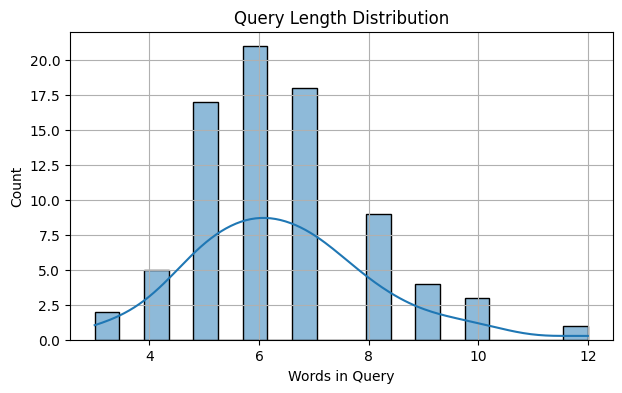

                                       query  \
0              What is paracetamol used for?   
1                How should I store insulin?   
2  Can I take ibuprofen on an empty stomach?   
3  Do I need a prescription for antibiotics?   
4         What is the dosage for cetirizine?   

                                            response  \
0  Paracetamol is commonly used to relieve mild t...   
1  Insulin should be stored in the refrigerator a...   
2  It's best to take ibuprofen with food or milk ...   
3  Yes, antibiotics typically require a doctor's ...   
4  The usual adult dose for cetirizine is 10 mg o...   

                     intent      domain  query_len  
0            medicine usage  healthcare          5  
1          medicine storage  healthcare          5  
2    medicine intake advice  healthcare          8  
3  prescription requirement  healthcare          7  
4        dosage information  healthcare          6  


In [ ]:

# ===================== 2. Load and Preprocess Dataset =====================

df = pd.read_csv("/content/data.csv")  # must contain 'query' and 'response' columns


print("DataFrame columns:", df.columns)

# Basic cleaning
df.dropna(inplace=True)


if 'query' in df.columns and 'response' in df.columns:
    df = df[df['query'].str.strip() != '']
    df = df[df['response'].str.strip() != '']
else:
    print("Error: 'query' or 'response' columns not found in the DataFrame.")



df['query_len'] = df['query'].apply(lambda x: len(x.split()))
plt.figure(figsize=(7,4))
sns.histplot(df['query_len'], bins=20, kde=True)
plt.title("Query Length Distribution")
plt.xlabel("Words in Query")
plt.grid(True)
plt.show()

# Show few examples
print(df.head())



In [ ]:

# ===================== 3. Tokenization & Dataset Preparation =====================
tokenizer = T5Tokenizer.from_pretrained("t5-small")

def tokenize(example):
    input_text = "question: " + example["query"]
    target_text = example["response"]
    tokenized_input = tokenizer(input_text, truncation=True, padding="max_length", max_length=64)
    tokenized_label = tokenizer(target_text, truncation=True, padding="max_length", max_length=64)
    tokenized_input["labels"] = tokenized_label["input_ids"]
    return tokenized_input

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.map(tokenize)
val_dataset = val_dataset.map(tokenize)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:

# ===================== 4. Model & Training =====================
model = T5ForConditionalGeneration.from_pretrained("t5-small")

training_args = TrainingArguments(
    output_dir="./medibot-model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    eval_strategy="epoch",
    logging_dir="./logs",
    save_total_limit=2,
)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

trainer.train()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<ipython-input-4-4b00a16d1bab>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ayushsinha5571 (ayushsinha5571-siksha-o-anusandhan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,0.003672
2,0.496900,0.000519
3,0.496900,0.000241
4,0.011100,0.000174
5,0.006200,0.000153


TrainOutput(global_step=1500, training_loss=0.17138680362701417, metrics={'train_runtime': 393.2882, 'train_samples_per_second': 30.512, 'train_steps_per_second': 3.814, 'total_flos': 203012702208000.0, 'train_loss': 0.17138680362701417, 'epoch': 5.0})

In [ ]:

# ===================== 5. Sample Predictions =====================
def chat(query):
    # Tokenize the input query
    input_ids = tokenizer("question: " + query, return_tensors="pt").input_ids
    device = model.device
    input_ids = input_ids.to(device)
    output_ids = model.generate(input_ids, max_length=64)

    # Decode the generated output IDs back to text
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Display few sample predictions
for i in range(5):
    # Access the 'query' column instead of 'question'
    q = val_df.iloc[i]["query"]
    # Access the 'response' column instead of 'answer'
    actual = val_df.iloc[i]["response"] # Changed from val_df.iloc[i]["answer"]
    pred = chat(q)
    print(f"\nQuery: {q}\nExpected: {actual}\nPredicted: {pred}")


Query: How can I schedule an appointment with my doctor?
Expected: You can schedule an appointment by calling our office or using our online portal.
Predicted: You can schedule an appointment by calling our office or using our online portal.

Query: What are the side effects of the COVID-19 vaccine?
Expected: Common side effects of the COVID-19 vaccine include soreness at the injection site, fever, and fatigue.
Predicted: Common side effects of the COVID-19 vaccine include soreness at the injection site, fever, and fatigue.

Query: How do I update my contact details on my account?
Expected: To update your contact details, log into your account and go to the 'Profile' section.
Predicted: To update your contact details, log into your account and go to the 'Profile' section.

Query: How can I schedule an appointment with my doctor?
Expected: You can schedule an appointment by calling our office or using our online portal.
Predicted: You can schedule an appointment by calling our office o

In [ ]:

# ===================== 6. BLEU Score Evaluation =====================
sample_refs = [[a.split()] for a in val_df['response'][:10]]
sample_preds = [chat(q).split() for q in val_df['query'][:10]]

bleu_scores = [sentence_bleu(ref, pred) for ref, pred in zip(sample_refs, sample_preds)]
print(f"\nAverage BLEU Score: {np.mean(bleu_scores):.4f}")


Average BLEU Score: 1.0000


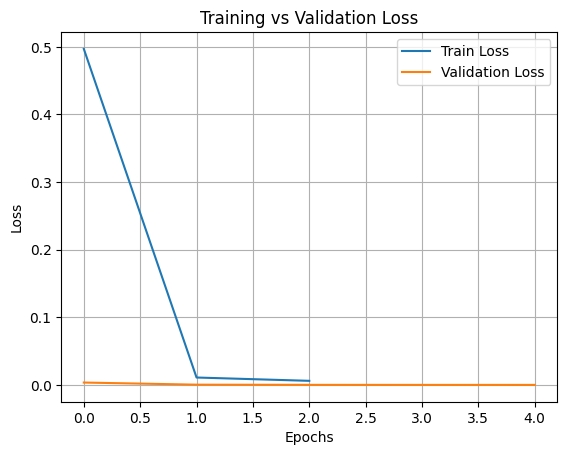

In [ ]:
# %%
# ===================== 7. Training Loss Visualization =====================
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

plt.plot(train_loss, label="Train Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

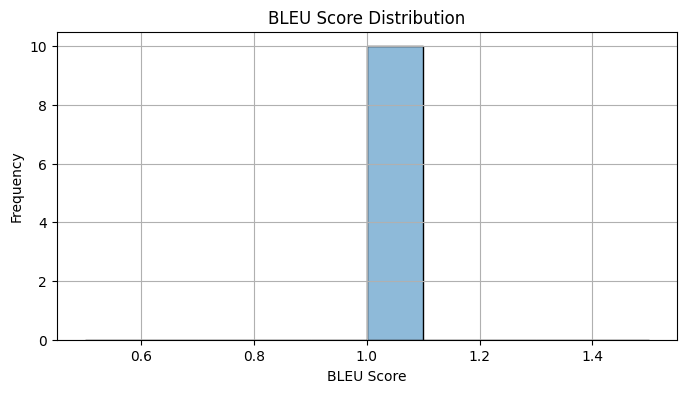

In [ ]:
import seaborn as sns

# Run this after calculating bleu_scores list
plt.figure(figsize=(8,4))
sns.histplot(bleu_scores, bins=10, kde=True)
plt.title("BLEU Score Distribution")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
